# Discretized Full Hamiltonian

#### **Tight-Binding Matrix** 

In [1]:
import numpy as np
from scipy.sparse import bmat
from scipy.linalg import ishermitian


# Hamiltonian parameters
params=dict(C0 = -0.0068, D1 = 1.3, D2 = 19.6, A1 = 2.2, A2 = 4.1, M = 0.28, B1 = 10, B2 = 56.6)

# Set of Pauli matrices for spin
sigma0 = np.array([[1, 0], [0, 1]])
sigmaX = np.array([[0, 1], [1, 0]])
sigmaY = np.array([[0, -1j], [1j, 0]])
sigmaZ = np.array([[1, 0], [0, -1]])

# Set of Pauli matrices for pseudo-spin
lambda0 = np.array([[1, 0], [0, 1]])
lambdaX = np.array([[0, 1], [1, 0]])
lambdaY = np.array([[0, -1j], [1j, 0]])
lambdaZ = np.array([[1, 0], [0, -1]])

# Set of Pauli matrices for particle-hole
tau0 = np.array([[1, 0], [0, 1]])
tauX = np.array([[0, 1], [1, 0]])
tauY = np.array([[0, -1j], [1j, 0]])
tauZ = np.array([[1, 0], [0, -1]])


# Function defining the Matrices a,b,c for the MTI
def abcMTI(kx, ky, L, C0 = -0.0068, D1 = 1.3, D2 = 19.6, A1 = 2.2, A2 = 4.1, M = 0.28, B1 = 10, B2 = 56.6):

    k = np.sqrt(kx**2+ky**2); e0 = C0 + D2*k**2; m0 = M - B2*k**2

    #matrix A
    amat = B1*np.kron(tauZ, np.kron(lambdaZ, sigma0)) - D1*np.kron(tauZ, np.kron(lambda0, sigma0))

    # matrix B
    bmat = -1j*A1*np.kron(tauZ, np.kron(lambdaX, sigmaZ))

    # matrix C
    cmat = e0*np.kron(tauZ, np.kron(lambda0, sigma0)) + L*np.kron(tauZ, np.kron(lambda0, sigmaZ)) + A2*( kx*np.kron(tauZ, np.kron(lambdaX, sigmaX)) + ky*np.kron(tauZ, np.kron(lambdaX, sigmaY)) ) + m0*np.kron(tauZ, np.kron(lambdaZ, sigma0))

    return [amat, bmat, cmat]


# Function defining the Matrices alpha and gamma for the SC
def abcSC(kx, ky, mu, Delta, t=1.):
        
    E0 = t*(kx**2+ky**2)

    # make Delta complex if real
    if isinstance(Delta, float):
        Delta = complex(Delta)

    # matrix alpha
    alpha = -t*np.kron(tauZ, sigma0)

    # matrix gamma 
    gamma = (E0-mu)*np.kron(tauZ, sigma0) - Delta.real*np.kron(tauY, sigmaY) - Delta.imag*np.kron(tauX, sigmaY)

    return [alpha, gamma]


# Function defining the Matrices A,B,C in the different cases
def ABCmatrices(kx, ky, mu, Delta, L, dZ, G, C0 = -0.0068, D1 = 1.3, D2 = 19.6, A1 = 2.2, A2 = 4.1, M = 0.28, B1 = 10, B2 = 56.6, t = 1.):

    # MTI a,b,c matrices
    a,b,c = abcMTI(kx=kx, ky=ky, L=L, C0=C0, D1=D1, D2=D2, A1=A1, A2=A2, M=M, B1=B1, B2=B2)

    # SC alpha and gamma matrices
    alpha, gamma = abcSC(kx=kx, ky=ky, mu=mu, Delta=Delta, t=1.) 

    # Gamma matrix in Nambu basis
    Gamma = np.block([[G, np.zeros((4,2))],[np.zeros((4,2)), -np.conj(G)]])
    
    # matrices for the MTI-SC heterostructure 
    A = np.block([[a, np.zeros((8,4))],[np.zeros((4,8)), alpha]])
    B = np.block([[b, np.zeros((8,4))],[np.zeros((4,8)), np.zeros((4,4))]])
    C = np.block([[c, np.zeros((8,4))],[np.zeros((4,8)), gamma]])

    # matrices for the SC part only 
    Asc = np.block([[np.zeros((8,8)), np.zeros((8,4))],[np.zeros((4,8)), alpha]])
    Csc = np.block([[np.zeros((8,8)), np.zeros((8,4))],[np.zeros((4,8)), gamma]])

    # matrix for tunneling interface
    Ctun = np.block([[c, Gamma],[np.conj(np.transpose(Gamma)), gamma]])
    
    return A, B, C, Asc, Csc, Ctun


# Build the tigh-binding hamiltonian (Nlat=lattice points, dZ=lattice spacing)
def TBham(Nlat, dZ, z0, z1, kx, ky, mu, Delta, L, G, C0 = -0.0068, D1 = 1.3, D2 = 19.6, A1 = 2.2, A2 = 4.1, M = 0.28, B1 = 10, B2 = 56.6, t = 1.):

    # get A,B,C matrices
    A,B,C, Asc,Csc, Ctun = ABCmatrices(kx=kx, ky=ky, mu=mu, Delta=Delta, L=L, dZ=dZ, G=G, C0=C0, D1=D1, D2=D2, A1=A1, A2=A2, M=M, B1=B1, B2=B2, t=t)

    # define a zero tight-binding matrix
    TBmat = [ [None for _ in range(Nlat) ] for _ in range(Nlat)]
		
	# loop over lattice sites
    for ilat in range(Nlat):
        
        # SC only 
        if ilat < z0 or ilat > z1:
            # on-site energy
            onsite = Csc - 2./np.power(dZ,2)*Asc;  
            # hopping energy
            hopping_plus = 1./np.power(dZ,2)*Asc
            # hopping minus
            hopping_minus = 1./np.power(dZ,2)*Asc
            
        # MTI-SC heterostructure 
        if ilat > z0 and ilat < z1:
            # on-site energy
            onsite = C - 2./np.power(dZ,2)*A;  
            # hopping energy
            hopping_plus = 1./np.power(dZ,2)*A + 1./(2.*dZ)*B
            # hopping minus
            hopping_minus = 1./np.power(dZ,2)*A - 1./(2.*dZ)*B
            
        # tunneling interface
        if ilat == z0:
            # on-site energy
            onsite = Ctun - 2./np.power(dZ,2)*A;  
            # hopping energy
            hopping_plus = 1./np.power(dZ,2)*A + 1./(2.*dZ)*B
            # hopping minus
            hopping_minus = 1./np.power(dZ,2)*Asc 

        # non-tunneling interface
        if ilat == z1:
            # on-site energy
            onsite = C - 2./np.power(dZ,2)*A;  
            # hopping energy
            hopping_plus = 1./np.power(dZ,2)*Asc
            # hopping minus
            hopping_minus = 1./np.power(dZ,2)*A - 1./(2.*dZ)*B

        
        # onsite diagonal energy 
        TBmat[ilat][ilat] = onsite
        # hopping energy (n+1)
        if ilat+1 < Nlat: TBmat[ilat][ilat+1] = hopping_plus
        # hopping energy (n-1)
        if ilat-1 > -1: TBmat[ilat][ilat-1] = hopping_minus

    return bmat(TBmat)


# lattice
Nlat = 300; d = 300.; dZ = d/(Nlat-1)
# parameters
mu = 0.010; Delta = 0.005; L = 0.005
# tunneling matrix
G = np.array([[1,0],[0,1],[1,0],[0,1]])

tb = TBham(Nlat=Nlat, dZ=dZ, z0=100, z1=200, kx=0., ky=0., mu=mu, Delta=Delta, L=L, G=G)
print(ishermitian(tb.toarray()))

True


#### **Eigenstates** 

In [2]:
from numpy.linalg import eigh
from scipy.sparse.linalg import eigsh

# Compute energy and wavefunctions in the full system
def eigenstates(Nlat, dZ, z0, z1, kx, ky, mu, Delta, L, G, C0 = -0.0068, D1 = 1.3, D2 = 19.6, A1 = 2.2, A2 = 4.1, M = 0.28, B1 = 10, B2 = 56.6, t = 1.):

    # number of components
    Nc = 12
    # thickness 
    d = (Nlat-1)*dZ
    # lattice
    lattice = np.linspace(0., d, num=Nlat)
    
    # build the tight-binding matrix
    tb = TBham(Nlat, dZ, z0, z1, kx, ky, mu, Delta, L, G, C0=C0, D1=D1, D2=D2, A1=A1, A2=A2, M=M, B1=B1, B2=B2, t=t)

    # solve the tight-binding problem
    if ishermitian(tb.toarray()) is True:
        egval, egvec = eigh(tb.toarray())
        #egval, egvec = eigsh(tb, k=3598)
    
    # indices sorted by absolute value
    idx_sort = np.argsort(np.abs(egval)) 
    # reorder egval 
    egval = egval[idx_sort]
    # reorder egvec 
    egvec = [egvec[:, idx] for idx in idx_sort]

    return lattice, egval, egvec


# get the spinors corresponding to e/h in MTI/SC
def getSpinors(egvec, Nlat, type='all'):

    # number of components
    Nc = 12
    
    match type:
        # electrons in MTI
        case 'eMTI':
            spinors = np.array([[ egv[Nc*ilat+0:Nc*ilat+4] for ilat in range(Nlat)] for egv in egvec])
        # holes in MTI
        case 'hMTI':
            spinors = np.array([[ egv[Nc*ilat+4:Nc*ilat+8] for ilat in range(Nlat)] for egv in egvec])
        # electrons in SC
        case 'eSC':
            spinors = np.array([[ egv[Nc*ilat+8:Nc*ilat+10] for ilat in range(Nlat)] for egv in egvec])
        # holes in SC
        case 'hSC':
            spinors = np.array([[ egv[Nc*ilat+10:Nc*ilat+12] for ilat in range(Nlat)] for egv in egvec])
        # full spinor in heterostructure
        case _:
            spinors = np.array([[ egv[Nc*ilat:Nc*ilat+12] for ilat in range(Nlat)] for egv in egvec])

    return spinors

## **Decoupled System**

In [4]:
# lattice
Nlat = 300; d = 300.; dZ = d/(Nlat-1)
# parameters
mu = 0.010; Delta = 0.005; L = 0.005
# tunneling matrix
G = np.array([[0,0],[0,0],[0,0],[0,0]])

# compute the eigenstates of uncoupled system
#lattice, egval_decoupled, egvec_decoupled = eigenstates(Nlat=Nlat, dZ=dZ, z0=100, z1=200, kx=0., ky=0., mu=mu, Delta=Delta, L=L, G=G)

# define lattice 
#lattice = np.linspace(0., d, num=Nlat)
# load eigenvalues from txt
#egval_decoupled = np.loadtxt("egval_decoupled.txt")
# load eigenvectors from txt
#egvec_decoupled = np.loadtxt("egvec_decoupled.txt", dtype=complex)

print(lattice.shape, egval_decoupled.shape, egvec_decoupled.shape)

(300,) (3600,) (3600, 3600)


#### <font color='green'> **Full Spectrum** </font> 

Surface states energy: 0.024596920795242012


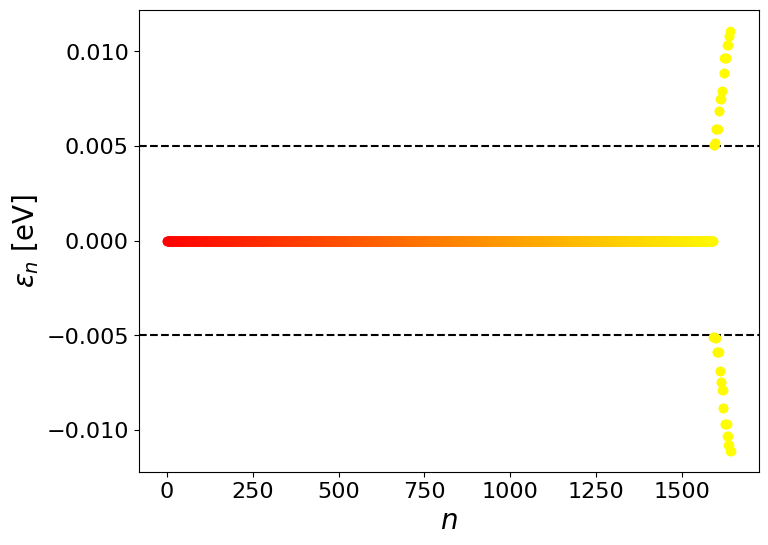

In [91]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm


# eigenvalues to plot
ngap = 1593; n0 = 1660; ntot = 3600; n = ngap + 50
# colors
cmap = plt.get_cmap('autumn', n)
# figure
fig, ax = plt.subplots(1,1, figsize=(8, 6))

# TSSs energy
#ax.axhline(y=egval_decoupled[n0], ls='--', color='black')
# SC gap
ax.axhline(y=Delta, ls='--', color='black'); ax.axhline(y=-Delta, ls='--', color='black')

# eigenvalue corresponding to TSSs
print('Surface states energy: ' + str(egval_decoupled[n0]))
# loop over eigenvalues
for iegv in range(n):

    # effective index 
    ieff = iegv
    # plot energy
    ax.plot(ieff, egval_decoupled[ieff], 'o', label='n=' + str(ieff), c=cmap(iegv));

#ax.legend(fontsize=15, ncol=2, loc='center right')
ax.set_xlabel('$n$', fontsize = 20)
ax.set_ylabel('$\epsilon_n$ [eV]', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16);

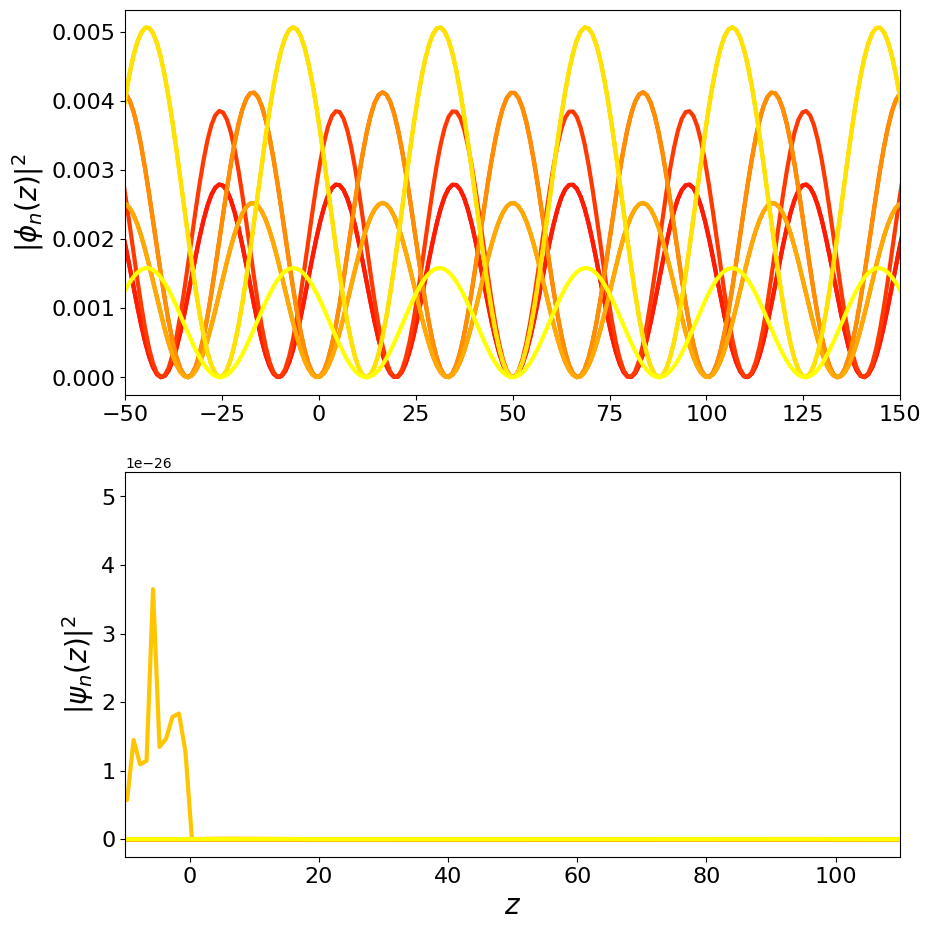

In [79]:
# get MTI spinors
#spinorsMTI = getSpinors(egvec_decoupled, Nlat, type='eMTI')
# get SC spinors
#spinorsSC = getSpinors(egvec_decoupled, Nlat, type='eSC')
# get full spinors
#spinors = getSpinors(egvec_decoupled, Nlat)


# eigenvalues to plot
n = 10
# colors
cmap = plt.get_cmap('autumn', n)
# figure
fig, ax = plt.subplots(2,1, figsize=(10, 11))


# loop over eigenvalues
for iegv in range(n):

    # effective index
    ieff = ngap + iegv
    
    # probability density for each lattice point for the SC states
    probdensSC = np.array([np.vdot(s, s) for s in spinorsSCh[ieff]]).real
    # plot probability density in SC
    ax[0].plot(lattice-100, probdensSC, label='n=' + str(ieff), lw=3, c=cmap(iegv))
    
    # probability density for each lattice point for the MTI states
    probdensMTI = np.array([np.vdot(s, s) for s in spinorsMTI[ieff]]).real
    # plot probability density in MTI
    ax[1].plot(lattice-100, probdensMTI, label='n=' + str(ieff), lw=3, c=cmap(iegv))

    #probdens = np.array([np.vdot(s, s) for s in spinors[ieff]]).real    
    #print(iegv, round(np.trapz(probdensSC, x=lattice),4), round(np.trapz(probdensMTI, x=lattice),4), round(np.trapz(probdens, x=lattice),4))


# SC plot 
ax[0].set_xlim(-50., 150.)
#ax[0].legend(fontsize=15, loc='upper center', ncol=3)
ax[0].set_ylabel('$|\phi_n(z)|^2$', fontsize = 20)
ax[0].tick_params(axis='both', which='major', labelsize=16);

# MTI plot
ax[1].set_xlim(-10., 110.)
#ax[1].legend(fontsize=15, loc='upper center', ncol=3)
ax[1].set_xlabel('$z$', fontsize = 20)
ax[1].set_ylabel('$|\psi_n(z)|^2$', fontsize = 20)
ax[1].tick_params(axis='both', which='major', labelsize=16);

#### <font color='green'> **MTI Spectrum** </font> 

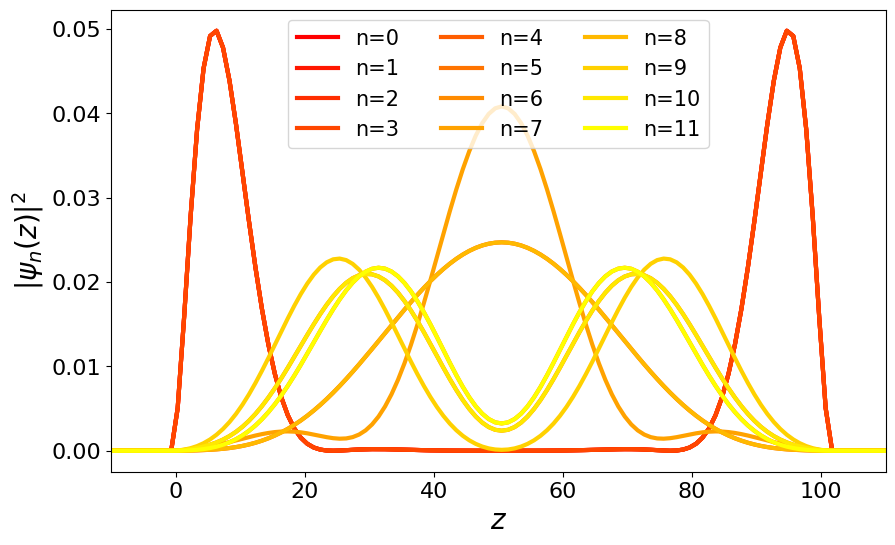

In [88]:
# eigenvalues to plot
n = 12
# colors
cmap = plt.get_cmap('autumn', n)
# figure
fig, ax = plt.subplots(1,1, figsize=(10, 6))


eMTI_states = 0; iegv = 0

# infinite loop 
while True:
    
    # effective index
    ieff = n0 + iegv
    
    # probability density for each lattice point for the MTI states
    probdensMTI = np.array([np.vdot(s, s) for s in spinorsMTI[ieff]]).real

    if np.trapz(probdensMTI, x=lattice) > 1E-5:
        # plot probability density in MTI
        ax.plot(lattice-100, probdensMTI, label='n=' + str(eMTI_states), lw=3, c=cmap(eMTI_states))
        # count MTI states
        eMTI_states += 1
        
    iegv +=  1

    # break condition
    if eMTI_states == n:
        break


ax.set_xlim(-10., 110.)
ax.legend(fontsize=15, loc='upper center', ncol=3)
ax.set_xlabel('$z$', fontsize = 20)
ax.set_ylabel('$|\psi_n(z)|^2$', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16);

### <font> Completeness </font> 

Below, we check that the states $\psi_{n, \, \sigma\lambda}(z)$ satisfies the *completeness relation*.
Recalling that $\psi_{n, \, \sigma\lambda}(z) = \braket{ z \sigma \lambda | n }$ we can write explicitly
$$
    \braket{ z \sigma \lambda | z' \sigma' \lambda' }
    =
    \sum_{n} \braket{ z \sigma \lambda | n } \braket{ n | z' \sigma' \lambda' }
    =
    \sum_{n} \psi_{n, \, \sigma \lambda}(z) \psi^\star_{n, \, \sigma' \lambda'}(z')
    =
    \delta_{\sigma \sigma'} \delta_{\lambda \lambda'} \delta(z-z') \,.
$$

In [ ]:
# iterations on eigenstates
N = np.arange(start=10, stop=101, step=10)

# figure
fig, ax = plt.subplots(1,1, figsize=(8,6))
# colors
cmap = plt.get_cmap('plasma', len(N))
# titles
title = ['$\sigma=\\uparrow, \lambda=+$', '$\sigma=\downarrow, \lambda=+$', '$\sigma=\\uparrow, \lambda=-$','$\sigma=\downarrow, \lambda=-$']

# z' position (between 0 and Nlat)
X = 200; ax.axvline(x=lattice[X], c='black', ls='dashed')

# spin lambda components
icomp = 1; jcomp = 1;

# loop over states
for idx in range(1,len(N)+1):

    # number of states
    Negv = N[-idx]
    # compute psi(x).psi^\star (x')
    delta = np.array([ np.sum([ spinors[iegv][x][icomp]*np.conj(spinors[iegv][X][jcomp]) for iegv in range(Negv)]) for x in range(Nlat) ])
    
    # plot the function on lattice
    ax.plot(lattice, delta.real, lw=2, c=cmap(idx), label='N = ' + str(Negv))

ax.set_title('z\' = ' + str(round(lattice[X],2)))
ax.legend(fontsize=15)
ax.set_xlabel('$z$', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16);

### <font> Orthonormality </font> 

Similarly, we can check that the energy states $\ket{n}$ are *orthonormal*, meaning that
$$
    \braket{ n | n'} = \sum_{\sigma\lambda} \int dz \, 
    \psi_{n, \, \sigma\lambda}^\star(z) \psi_{n', \, \sigma\lambda}(z)
    =
    \delta_{nn'}\,,
$$

In [ ]:
spinors = getSpinors(egvec_decoupled, Nlat)

# iteration
N = 10

# figure
fig, ax = plt.subplots(1,1, figsize=(8,6))
# colors
cmap = plt.get_cmap('plasma', N)

# diagonal product
deltann = np.array([ np.trapz( [np.vdot(s[iLat], s[iLat]) for iLat in range(Nlat)], x=lattice ) for s in spinors])
# plot diagonal product
ax.plot( np.arange(len(egval_decoupled)), deltann.real, label='n=n', lw=2, c='black')

for idx in range(1,N,1):

    # off-diagonal product
    deltanm = np.array([ np.trapz( [np.vdot(spinors[iegv][iLat], spinors[iegv+idx][iLat]) for iLat in range(Nlat)], x=lattice ) for iegv in range(len(egval_decoupled)-idx)])
    
    # label
    label = '$n\'=n + $' + str(idx) 
    # plot off-diagonal product
    ax.plot( np.arange(len(egval_decoupled)-idx), deltanm.real, label=label, lw=2, c=cmap(idx))


ax.set_xlabel('n', fontsize = 20)
ax.set_ylabel('$\langle n | n\' \\rangle$', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=15, ncol=2);

### <font> Convergence  </font> 
We investigate here the convergence of the wavefunctions $\psi_n(z)$ for an increasing number of lattice sites.

In [ ]:
# state index
n = 5
# lattice
Nlat = np.arange(25,201,25); d = 100.; dZ = [d/(n-1) for n in Nlat]

# figure
fig, ax = plt.subplots(1,1, figsize=(8,6))
# colors
cmap = plt.get_cmap('viridis_r', len(Nlat))

 
# loop over lattices
for iNlat in range(len(Nlat)):
      
    # total number of states
    Ntot = 4*Nlat[iNlat]
        
    # eigenstates
    lattice, egval, spinors = eigenstates(Nlat=Nlat[iNlat], dZ=dZ[iNlat], kx=0., ky=0., L=0.)
   
    # probability density for each lattice point
    probdens = np.array([np.dot(np.conjugate(s), s) for s in spinors[n]]).real

    print(Nlat[iNlat], egval[n])
    
    # label
    label = '$N_{lat}$ = ' + str(Nlat[iNlat])   
    # plot the probability density
    ax.plot( lattice, probdens, label=label, lw=2, c=cmap(iNlat))


ax.set_title('Wavefunction n = ' + str(n))
ax.set_xlabel('$z$', fontsize = 20)
ax.set_ylabel('$|\psi_n(z)|^2$', fontsize = 20)

ax.legend(fontsize=15, ncol=1)
ax.tick_params(axis='both', which='major', labelsize=16);

### <font> **Green's Function** </font> 

The goal here is to compute the time-ordered (in real time) Green's function $\mathcal{G}^{(0)}_{MTI}$ using the wavefunctions $\psi_{n, \, \sigma\lambda}$ previously obtained by discretizing the 3D MTI Hamiltonian $h_{MTI}$ on a finite lattice along the $z$ direction.
In an MTI slab with a finite thickness $d$ along $z$ and translational invariance along $x$ and $y$, the real-time Green's function is given by
$$
    \newcommand{\T}{\hat{T}_t \,}
	\mathcal{G}^{(0)}_{\sigma\lambda, \sigma'\lambda'}(zt,z't') =
	-i \left\langle
	\T \hat{\psi}_{\sigma \lambda}(zt) \hat{\psi}^\dagger_{\sigma' \lambda'}(z't')
	\right\rangle_0 \,,
$$
where $\hat{\psi}^\dagger_{\sigma \lambda}(zt)$ $(\hat{\psi}_{\sigma \lambda}(zt))$ creates (annihilates) an electron with spin $\sigma$ and parity $\lambda$ at position $z$ and time $t$.
Here, $\langle \dots \rangle_0$ indicates that the average is on the unperturbed ground state.
For the sake of clarity, we omitted the indices for the in-plane wavenumbers $k_x$ and $k_y$.
Writing explicitly the time-evolution in the Heisenberg picture, the field operators can be expanded in terms of the wavefunctions $\psi_{n, \, \sigma\lambda}$ as
$$
    \hat{\psi}_{\sigma \lambda}(zt) = 
    \sum_{n=0}^{+\infty} e^{-i \epsilon_n t /\hbar} \psi_{n, \, \sigma\lambda}(z) \hat{c}_{n} \,,
    \qquad
    \hat{\psi}^\dagger_{\sigma \lambda}(zt) = 
    \sum_{n=0}^{+\infty} e^{i \epsilon_n t/\hbar} \psi_{n, \, \sigma\lambda}^\star(z) \hat{c}^\dagger_{n} \,,
$$
where $\hat{c}^\dagger_{n}$ $(\hat{c}_{n})$ is the creation (annihilation) operator for an electron in the quantum state $\ket{n}$.
Making explicit the action of the time-ordering operator, the Green's function takes the following form
$$
    \mathcal{G}^{(0)}_{\sigma\lambda, \sigma'\lambda'}(zt,z't') =
	-i \theta(t-t') \left\langle  \hat{\psi}_{\sigma \lambda}(zt) \hat{\psi}^\dagger_{\sigma' \lambda'}(z't') \right\rangle_0
     +
     i \theta(t'-t) \left\langle \hat{\psi}^\dagger_{\sigma' \lambda'}(z't') \hat{\psi}_{\sigma \lambda}(zt) \right\rangle_0 \,.
$$
The first term in the previous equation can be rewritten as
$$
\begin{split}
    \left\langle \hat{\psi}_{\sigma \lambda}(zt) \hat{\psi}^\dagger_{\sigma' \lambda'}(z't') \right\rangle_0
    &=
    \sum_{n m} 
    e^{-i \left( \epsilon_n t - \epsilon_{m} t' \right)/\hbar } 
    \psi_{n, \, \sigma\lambda}(z) \psi_{m, \, \sigma'\lambda'}^\star(z') 
    \left\langle \hat{c}_{n} \hat{c}^\dagger_{m} \right\rangle_0 = \\[5pt]
    %%%
    &=
    \sum_{n m} 
    e^{-i \left( \epsilon_n t - \epsilon_{m} t' \right)/\hbar } 
    \psi_{n, \, \sigma\lambda}(z) \psi_{m, \, \sigma'\lambda'}^\star(z') 
    \left\langle 
        \delta_{nm} -
        \hat{c}^\dagger_{m} \hat{c}_{n} 
    \right\rangle_0 = \\[5pt]
    %%%
    &=
    \sum_{n m} \delta_{nm}
    e^{-i \left( \epsilon_n t - \epsilon_{m} t' \right)/\hbar } 
    \psi_{n, \, \sigma\lambda}(z) \psi_{m, \, \sigma'\lambda'}^\star(z') 
    \left\langle 
        1 -
        \hat{c}^\dagger_{n} \hat{c}_{n} 
    \right\rangle_0 = \\[5pt]
    %%%
    &= \sum_{n} 
    e^{-i \epsilon_n \left( t-t' \right)/\hbar } 
    \psi_{n, \, \sigma\lambda}(z) \psi_{n, \, \sigma'\lambda'}^\star(z') 
    \left\langle 
        1 -
        \hat{n}_{n}
    \right\rangle_0 \,,
\end{split}
$$
where in the third row we observed that the average in the unperturbed ground state is nonzero only if the operators $\hat{c}_{n}$ and $\hat{c}^\dagger_{m}$ act on the same quantum state, i.e.
$$
    \left\langle \delta_{nm} - \hat{c}^\dagger_{m} \hat{c}_{n} \right\rangle_0 
    =
    \delta_{nm}  \left\langle 1 - \hat{c}^\dagger_{n} \hat{c}_{n} \right\rangle_0 \,.
$$
Similarly, the second term in the Green's function expansion can be expressed as
$$
    \left\langle  \hat{\psi}^\dagger_{\sigma' \lambda'}(z't') \hat{\psi}_{\sigma \lambda}(zt) \right\rangle_0
    = \sum_{n} 
    e^{-i \epsilon_n \left( t-t' \right)/\hbar } 
    \psi_{n, \, \sigma\lambda}(z) \psi_{n, \, \sigma'\lambda'}^\star(z') 
    \left\langle 
        \hat{n}_{n}
    \right\rangle_0 \,.
$$
Here, $\hat{n}_{n} \equiv \hat{c}^\dagger_{n} \hat{c}_{n}$ is the number operator which counts the number of electrons in the state $\ket{n}$.
For non-interacting fermions its average value is given by the Fermi-Dirac distribution
$$
    \left\langle \hat{n}_{n} \right\rangle_0
    =
    \frac{1}{e^{\beta(\epsilon_n-E_F)} + 1} \,,
$$
where $\beta = 1/k_B T$ is the inverse temperature.
In the zero temperature limit we can thus write $\left\langle \hat{n}_{n} \right\rangle_0 = \theta(E_F-\epsilon_n)$ and $\left\langle 1-\hat{n}_{n} \right\rangle_0 = \theta(\epsilon_n-E_F)$.
With such expansions, the real-time Green's function can be expressed in terms of the wavefunctions $\psi_{n, \, \sigma\lambda}(zt)$ as 
$$
\begin{split}
    \mathcal{G}^{(0)}_{\sigma\lambda, \sigma'\lambda'}(zt,z't') 
    &=
	-i \theta(t-t') \left\langle  \hat{\psi}_{\sigma \lambda}(zt) \hat{\psi}^\dagger_{\sigma' \lambda'}(z't') \right\rangle_0
     +
     i \theta(t'-t) \left\langle \hat{\psi}^\dagger_{\sigma' \lambda'}(z't') \hat{\psi}_{\sigma \lambda}(zt) \right\rangle_0 = \\[5pt]
     %%%
     &=
     \sum_{n} 
    e^{-i \epsilon_n \left( t-t' \right)/\hbar } 
    \psi_{n, \, \sigma\lambda}(z) \psi_{n, \, \sigma'\lambda'}^\star(z')
    \Bigl\lbrack
    -i \theta(t-t') \left\langle 1-\hat{n}_{n} \right\rangle_0
    +
    i \theta(t'-t) \left\langle \hat{n}_{n} \right\rangle_0
    \Bigr\rbrack \,.
\end{split}
$$

#### **Angular Green's Function** </font> 


The corresponding expression for the angular Green's function in frequency space can be obtained through the following Fourier transform 
$$
    \mathcal{G}^{(0)}_{\sigma\lambda, \sigma'\lambda'}(z,z'; t-t') 
    =
    \frac{1}{2\pi} \int d\omega \,
    e^{-i \omega(t-t')} \mathcal{G}^{(0)}_{\sigma\lambda, \sigma'\lambda'}(z,z'; \omega) \,.
$$
Using the following identity
$$
    -i\theta(t-t') e^{-Et} = \lim_{\eta \rightarrow 0^+} \frac{1}{2\pi} \int d\omega \,
    \frac{e^{-i \omega(t-t')}}{\omega-E+i\eta} \,,
$$
it is possible to rewrite the first term in the previous expansion as
$$
     -i \theta(t-t') e^{-i \epsilon_n \left( t-t' \right)/\hbar }
    =
    \lim_{\eta \rightarrow 0^+} \frac{1}{2\pi} \int d\omega \,
    \frac{e^{-i \omega(t-t')}}{\omega - \epsilon_n/\hbar + i\eta} \,,
$$
while the second one becomes
$$
    i \theta(t'-t) e^{-i \epsilon_n \left( t-t' \right)/\hbar }
    =
    - \lim_{\eta \rightarrow 0^+} \frac{1}{2\pi} \int d\omega \,
    \frac{e^{-i \omega(t'-t)}}{\omega + \epsilon_n/\hbar + i\eta} \,.
$$
Plugging these expressions in the previous expansion we have
$$
\begin{split}
    \mathcal{G}^{(0)}_{\sigma\lambda, \sigma'\lambda'}(zt,z't') 
    &=
    \sum_{n} 
    e^{-i \epsilon_n \left( t-t' \right)/\hbar } 
    \psi_{n, \, \sigma\lambda}(z) \psi_{n, \, \sigma'\lambda'}^\star(z')
    \Bigl\lbrack
    -i \theta(t-t') \left\langle 1-\hat{n}_{n} \right\rangle_0
    +
    i \theta(t'-t) \left\langle \hat{n}_{n} \right\rangle_0
    \Bigr\rbrack = \\[5pt]
    %%%
    &=
    \sum_{n} 
    \psi_{n, \, \sigma\lambda}(z) \psi_{n, \, \sigma'\lambda'}^\star(z')
    \lim_{\eta \rightarrow 0^+} \frac{1}{2\pi} \int d\omega \,
    \Biggl\lbrack
    \frac{e^{-i \omega(t-t')}}{\omega - \epsilon_n/\hbar + i\eta} 
    \left\langle 1-\hat{n}_{n} \right\rangle_0
    -
    \frac{e^{-i \omega(t'-t)}}{\omega + \epsilon_n/\hbar + i\eta}
    \left\langle \hat{n}_{n} \right\rangle_0
    \Biggr\rbrack \,.
\end{split}
$$
The second term in the integral can be rewritten as
$$
\begin{split}
    \int_{-\infty}^{+\infty} d\omega \,
    \frac{e^{-i \omega(t'-t)}}{\omega + \epsilon_n/\hbar + i\eta}
    \left\langle \hat{n}_{n} \right\rangle_0
    &=
    -\int_{+\infty}^{-\infty} d\omega' \,
    \frac{e^{i \omega'(t'-t)}}{-\omega' + \epsilon_n/\hbar + i\eta}
    \left\langle \hat{n}_{n} \right\rangle_0 = \\[5pt]
    %%%
    &=
    - \int_{-\infty}^{+\infty} d\omega' \,
    \frac{e^{-i \omega'(t-t')}}{\omega' - \epsilon_n/\hbar - i\eta}
    \left\langle \hat{n}_{n} \right\rangle_0 \,,
\end{split}
$$
where in the second line $\omega' = - \omega$.
Plugging this equation into the previous one we obtain 
$$
\begin{split}
    \mathcal{G}^{(0)}_{\sigma\lambda, \sigma'\lambda'}(z,z';t-t') 
    &=
    \sum_{n} 
    \psi_{n, \, \sigma\lambda}(z) \psi_{n, \, \sigma'\lambda'}^\star(z')
    \lim_{\eta \rightarrow 0^+} \frac{1}{2\pi} \int d\omega \,
    \Biggl\lbrack
    \frac{e^{-i \omega(t-t')}}{\omega - \epsilon_n/\hbar + i\eta} 
    \left\langle 1-\hat{n}_{n} \right\rangle_0
    -
    \frac{e^{-i \omega(t'-t)}}{\omega + \epsilon_n/\hbar + i\eta}
    \left\langle \hat{n}_{n} \right\rangle_0
    \Biggr\rbrack = \\[5pt]
    %%%
    &=
    \sum_{n} 
    \psi_{n, \, \sigma\lambda}(z) \psi_{n, \, \sigma'\lambda'}^\star(z')
    \lim_{\eta \rightarrow 0^+} \frac{1}{2\pi} \int d\omega \,
    e^{-i \omega(t-t')}
    \Biggl\lbrack
    \frac{\left\langle 1-\hat{n}_{n} \right\rangle_0}{\omega - \epsilon_n/\hbar + i\eta} 
    +
    \frac{\left\langle \hat{n}_{n} \right\rangle_0}{\omega - \epsilon_n/\hbar - i\eta}
    \Biggr\rbrack \,,
\end{split}
$$
where we can recognize the angular Green's function as
$$
    \mathcal{G}^{(0)}_{\sigma\lambda, \sigma'\lambda'}(z,z'; \omega)
    =
    \sum_{n} 
    \psi_{n, \, \sigma\lambda}(z) \psi_{n, \, \sigma'\lambda'}^\star(z')
    \lim_{\eta \rightarrow 0^+} 
    \Biggl\lbrack
    \frac{\left\langle 1-\hat{n}_{n} \right\rangle_0}{\omega - \epsilon_n/\hbar + i\eta} 
    +
    \frac{\left\langle \hat{n}_{n} \right\rangle_0}{\omega - \epsilon_n/\hbar - i\eta}
    \Biggr\rbrack \,.
$$
Taking the limit of zero temperature, we obtain
$$
\begin{split}
    \mathcal{G}^{(0)}_{\sigma\lambda, \sigma'\lambda'}(z,z'; \omega)
    &=
    \sum_{n} 
    \psi_{n, \, \sigma\lambda}(z) \psi_{n, \, \sigma'\lambda'}^\star(z')
    \lim_{\eta \rightarrow 0^+} 
    \Biggl\lbrack
    \frac{\theta(\epsilon_n-E_F)}{\omega - \epsilon_n/\hbar + i\eta} 
    +
    \frac{\theta(E_F-\epsilon_n)}{\omega - \epsilon_n/\hbar - i\eta}
    \Biggr\rbrack = \\[5pt]
    %%%
    &=
    \lim_{\eta \rightarrow 0^+} \sum_{n} 
    \psi_{n, \, \sigma\lambda}(z) \psi_{n, \, \sigma'\lambda'}^\star(z')
    \frac{1}{\omega - \epsilon_n/\hbar + i\eta \text{sgn}(\epsilon_n-E_F)} \,.
\end{split}
$$


In [ ]:
# Function evaluating the Green's function from wavefunctions (Z=z', d=thickness)
def GF(Nstates, egval, spinors, z, Z, w, eta = 1E-9, EF = 0., hbar = 1.):
    
    # empty matrix for Green's function
    gf = np.zeros([4, 4], dtype='complex')

    # loop over columns of GF
    for icol in range(4):
        # loop over rows of GF
        for irow in range(4):

            # sum over Nstates
            for istate in range(Nstates):
                # psi
                psi = spinors[istate][z][irow]
                # psi star
                psistar = np.conjugate(spinors[istate][Z][icol])
                # energy
                en = egval[istate]
                # perform sum over states
                gf[irow][icol] += psi*psistar/(w-en/hbar+1j*eta*np.sign(en-EF))

    return gf

### <font> Green's Function for $z=z'$ </font> 
We plot here the Green's function $\mathcal{G}^{(0)}(z,z;\omega)$ as a function of the out-of-plane coordinate $z$ and with $z'=z$.

#### Convergence over States 
The following plots show the Green's function computed using an increasing number of discrete energy states obtained using the **same** discrete **lattice**.

In [ ]:
from GreenFunctions_MTI import GMTI_diagonal

# parameters
kx = 0.; ky = 0.; L = 0.; w=0.01
# lattice
Nlat = 250; d = 100.; dZ = d/(Nlat-1)
# eigenstates
lattice, egval, spinors = eigenstates(Nlat=Nlat, dZ=dZ, kx=kx, ky=ky, L=L,  A1=0., A2=0.)


# number of states for loop
Nstates = [50,100,250,500]

# array for Green's function
gf = []
# loop over increasing subset of states
for idx in range(len(Nstates)):
    
    # compute approximate Green's function with all states
    gf.append( np.array([GF(Nstates[idx], egval, spinors, z=z, Z=z, w=w, eta=1E-16) for z in range(Nlat)]) )
    # print for each susbset
    print('Sum over ' + str(Nstates[idx]) + ' states')


# analytical solution for diagonal Hamiltonian
gfdiagonal = np.array([GMTI_diagonal(d=d, z=z, Z=z, kx=kx, ky=ky, L=L, w=w) for z in lattice])

#### <font color='green'> **Real Part** </font> 

In [ ]:
# colors gradient
cmap = plt.get_cmap('autumn_r', len(Nstates))

# titles for subplots
title = ["$g_{\\uparrow +, \\uparrow +}$", "$g_{\downarrow +, \downarrow +}$", "$g_{\\uparrow -, \\uparrow -}$", "$g_{\downarrow -, \downarrow -}$"]


# subplots
fig, axs = plt.subplots(2,2, figsize=(20, 20))

# indices referred to diagonal components
for icomp in range(4):
        
    # indices for plotting
    if icomp==0: iPic = 0; jPic = 0
    if icomp==1: iPic = 0; jPic = 1
    if icomp==2: iPic = 1; jPic = 0
    if icomp==3: iPic = 1; jPic = 1
    
    for iegv in range(len(Nstates)):

        # plot approximate results
        axs[iPic][jPic].plot(lattice, [gf[iegv][iz][icomp][icomp].real for iz in range(Nlat)], c=cmap(iegv), lw=2, label='$N_{states}$ = ' + str(Nstates[iegv]) )

    # Green's function from trivial solution
    axs[iPic][jPic].plot(lattice, gfdiagonal[:,icomp].real, '--', c='black', lw=2.5, label='analytical');

    axs[iPic][jPic].set_title(title[icomp], fontsize = 20)

    #axs[iPic][jPic].set_ylim(-0.5,0.5)
    axs[iPic][jPic].set_xlabel("$z=z'$", fontsize = 20)
    axs[iPic][jPic].set_ylabel("$g_{\sigma\lambda, \sigma'\lambda'}(z,z;\omega)$", fontsize = 20)
        
    axs[iPic][jPic].tick_params(axis='both', which='major', labelsize=14)        
    axs[iPic][jPic].legend(fontsize=15);

#### <font color='green'> **Imaginary Part** </font> 

In [ ]:
# colors gradient
cmap = plt.get_cmap('winter_r', len(Nstates))

# subplots
fig, axs = plt.subplots(2,2, figsize=(20, 20))

# indices referred to diagonal components
for icomp in range(4):
        
    # indices for plotting
    if icomp==0: iPic = 0; jPic = 0
    if icomp==1: iPic = 0; jPic = 1
    if icomp==2: iPic = 1; jPic = 0
    if icomp==3: iPic = 1; jPic = 1
    
    for iegv in range(len(Nstates)):

        # plot approximate results
        axs[iPic][jPic].plot(lattice, [gf[iegv][iz][icomp][icomp].imag for iz in range(Nlat)], c=cmap(iegv), lw=2, label='$N_{states}$ = ' + str(Nstates[iegv]) )

    # Green's function from trivial solution
    axs[iPic][jPic].plot(lattice, gfdiagonal[:,icomp].imag, '--', c='black', lw=2, label='analytical');

    axs[iPic][jPic].set_title(title[icomp], fontsize = 20)

    #axs[iPic][jPic].set_ylim(-0.5,0.5)
    axs[iPic][jPic].set_xlabel("$z=z'$", fontsize = 20)
    axs[iPic][jPic].set_ylabel("$g_{\sigma\lambda, \sigma'\lambda'}(z,z;\omega)$", fontsize = 20)
        
    axs[iPic][jPic].tick_params(axis='both', which='major', labelsize=14)        
    axs[iPic][jPic].legend(fontsize=15);